---

## 16 - FEC Channel Simulation
This is the third notebook in the series exploring Soft Decision Forward Error Correction (SD-FEC) on RFSoC. In previous notebooks we have learned the underlying principals of forward error correction and have used an SD-FEC integrated block to encode data in the programmable logic of the RFSoC. In this notebook we will simulate an additive white Gaussian noise (AWGN) channel for our encoded data to pass through. 

## Table of Contents
* [1. Introduction](#nb3_introduction)
    * [1.1. Overview](#nb3_overview)
    * [1.2. Notebook Setup](#nb3_notebook_setup)
* [2. Symbol Mapping (Baseband Modulation)](#symbol_mapping)
* [3. AWGN](#awgn)
    * [3.1. Calculate Noise Variance](#calculate_noise_variance)
    * [3.2. Generate Noise Signal](#generate_noise_signal)
    * [3.3. Add Noise](#add_noise)
* [4. Log Likelihood Ratio (Soft Demodulation)](#llr)
* [5. Conclusion](#nb3_conclusion)

## References
* [1] - [AMD-Xilinx, "Soft-Decision FEC Integrated Block v1.1: LogiCORE IP Product Guide", October 2022](https://docs.xilinx.com/r/en-US/pg256-sdfec-integrated-block)
* [2] - [Krishna Sankar, "Softbit for 16QAM", July 2009](http://www.dsplog.com/2009/07/05/softbit-16qam/)


---


## 1. Introduction <a class="anchor" id="nb3_introduction"></a>
The purpose of error correction codes is to identify and fix errors in a data block that result from damage or noise. As these notebooks are focused on radio applications using the bladeRF, our encoded data will be exposed to an AWGN channel as part of a simplified radio pipeline. Our encoded data will first be baseband modulated using a 16-QAM scheme, then exposed to an AWGN channel, and finally baseband demodulated using soft decisions. The resulting data will be noisy encoded data in the form of soft bits.


### 1.2. Notebook Setup <a class="anchor" id="nb3_notebook_setup"></a>
We setup the notebook by importing the required Python libraries and the encoded data from the previous notebook (or file).

no stored variable or alias tx_enc_buf
no stored variable or alias rx_bits


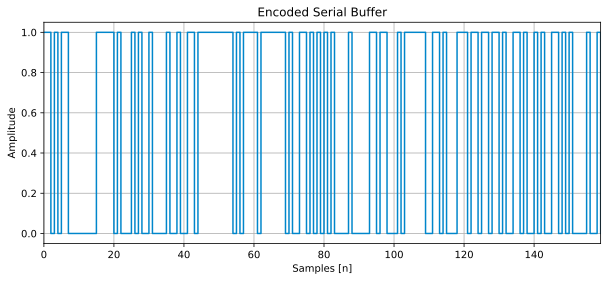

In [14]:
import numpy as np
import math
import strath_sdfec.helper_functions as hf

%store -r tx_enc_buf rx_bits

if 'rx_bits' not in locals():
    print('No stored data found, importing from file..')
    tx_enc_buf = np.loadtxt('data/docsis_init_ranging_tx.txt')
    rx_bits = np.loadtxt('data/docsis_init_ranging_rx.txt')
    
hf.plot_samples('Encoded Serial Buffer',
                [range(len(rx_bits))],
                [rx_bits])

## 2. Baseband Modulation <a class="anchor" id="symbol_mapping"></a>
The first stage in the simplified radio pipeline is baseband modulation. For digital data to be sent over a wireless communications channel, the serial bits must first be converted to voltage amplitude levels. This conversion is called baseband modulation or bit-to-symbol mapping. This process involves dividing the serial bits into groups of a certain length. These groups are referred to as symbols and each symbol will have an associated voltage level or levels in the case of complex signals. How the symbols are mapped to a voltage level is determined by the modulation scheme employed. In this notebook, we use the 16-QAM scheme and Gray coding, where adjacent symbols differ by only 1 bit. Figure 2 depicts a constellation of the symbol mapping used.

<a class="anchor" id="fig-2"></a>
<center><figure>
<img src='../img/symbol_mapping.png' width='800'/>
    <figcaption><b>Figure 2: Gray coded symbol mapping constellation for 16-QAM.</b></figcaption>
</figure></center>

By grouping bits together and assigning them a specific amplitude level, more data is able to be transmitted per sample. The more bits that form a symbol, the higher the transmission data rate is. However, you will notice that this also means that there is less space between symbols in the constellation, meaning the signal is more susceptible to noise. The 16-QAM scheme has a total of 16 symbols meaning each symbol is made up of 4 bits. From this constellation, we can easily see that the two most significant bits are responsible for the real amplitude level and the two least significant bits determine the imaginary amplitude level. 

We can write a function that loops through a serial bit-stream in groups of 4 bits and ascertains the real and imaginary amplitude levels by comparing the two MSBs and two LSBs to certain bit patterns as detailed in the constellation diagram. In the cell below, we do exactly that, and the function returns a baseband modulated complex signal.

In [15]:
def symbol_map(serial_data):
    mod_I = np.empty(0)
    mod_Q = np.empty(0)
    
    # Iterate through serial bits in increments of 4
    for i in range(0, len(serial_data), 4):
        symbol = serial_data[i : i+4]    # Group 4 bits

        b3b2 = symbol[0:2]    # MSBs
        b1b0 = symbol[2:4]    # LSBs

        # Real amplitude
        if np.array_equal(b3b2,[0,0]):
            I = -3
        elif np.array_equal(b3b2,[0,1]):
            I = -1
        elif np.array_equal(b3b2,[1,1]):
            I = 1
        elif np.array_equal(b3b2,[1,0]):
            I = 3

        # Imaginary amplitude
        if np.array_equal(b1b0,[0,0]):
            Q = 3
        elif np.array_equal(b1b0,[0,1]):
            Q = 1
        elif np.array_equal(b1b0,[1,1]):
            Q = -1
        elif np.array_equal(b1b0,[1,0]):
            Q = -3

        mod_I = np.append(mod_I, I)
        mod_Q = np.append(mod_Q, Q)
        
    signal = mod_I + 1j*mod_Q   
    return signal

Using the function defined above, we can plot the samples of our new signal as well as a constellation diagram. 

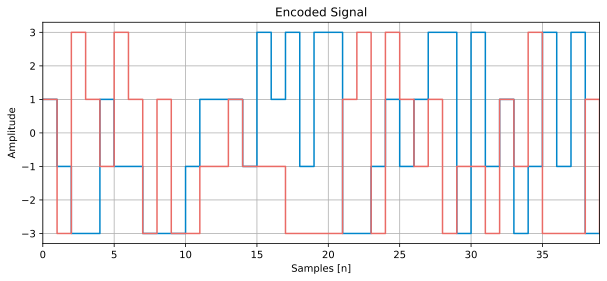

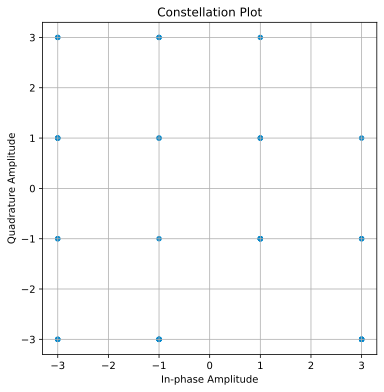

In [16]:
signal = symbol_map(rx_bits)

hf.plot_samples('Encoded Signal',
                [range(len(signal)),range(len(signal))],
                [np.real(signal),np.imag(signal)])

hf.plot_constellation(signal)

Our encoded data has been converted from a stream of individual bits (0s and 1s) of length *L* to a complex 16-QAM signal of length *L*/4 that has 4 amplitude levels in both the real and imaginary domain. 

## 3. AWGN Channel <a class="anchor" id="awgn"></a>
We will now subject our signal to noise that we can control the level of. To achieve this, we will create a second signal of normally distributed random numbers that will act as our noise and be added to our data signal. We must be able to adjust the spread of this new signal's amplitude such that, when added to our data signal, will result in a desired Signal-to-Noise Ratio (SNR). The following subsections outline this process.

### 3.1. Calculate Noise Variance <a class="anchor" id="calculate_noise_variance"></a>
Variance is the measure of spread around the mean. If we take the equation of Signal-to-Noise Ratio expressed in decibels:

$$
    \mathit{SNR\;(dB)} =  10\log_{10} \left(\frac{\sigma^2_{signal}}{\sigma^2_{noise}}\right)
$$
We can rearrange for noise variance:
$$
    \sigma^2_{noise} = \frac{\sigma^2_{signal}}{10^{\frac{\mathit{\;SNR\;(dB)}}{10}}}
$$

This allows us to update the SNR value and obtain the variance that the noise must have to result in our desired SNR. The cell below performs this calculation. While the signal variance is measured here, it is known that for the 16-QAM scheme employed and the amplitude levels used, the resulting signal variance will be 10 provided the mapped bits are randomly generated with uniform distribution. The more bits measured over, the more accurate this result will be.

In [4]:
SNR = 15

snr_ratio = 10**(SNR/10)
var_signal = np.var(signal)
var_noise = var_signal / snr_ratio

print('Desired SNR: %d dB' % SNR)
print('Signal Variance:', var_signal)
print('Noise Variance:' ,var_noise)
print('SNR (ratio):', var_signal/var_noise)

Desired SNR: 15 dB
Signal Variance: 9.397499999999999
Noise Variance: 0.2971750431143234
SNR (ratio): 31.622776601683793


### 3.2. Generate Noise Signal <a class="anchor" id="generate_noise_signal"></a>
Our noise signal is to be complex and therefore the calculated variance applies to this complex signal. To create a complex noise signal with the calculated variance we must create two separate noise signals, one to act as the real component and the other the imaginary. Each noise signal should have half of the calculated variance as, when combined, this will result in a signal with our total calculated variance. Another way to think about this is in terms of power. When we have zero mean, power and variance are equal. Therefore, if we have a complex signal of a certain power, this will comprise two independent signals each with half of the stated power.

We can generate the real and imaginary components of the noise signal using *np.random.normal()*. This function takes three arguments: mean, standard deviation and size.

In [5]:
std_noise = math.sqrt(var_noise/2)     # Standard deviation of 1-D noise signal
mean_noise = 0
len_noise = len(signal)

noise_I = np.random.normal(mean_noise,std_noise,len_noise)
noise_Q = np.random.normal(mean_noise,std_noise,len_noise)

noise = noise_I + 1j*noise_Q

In the cell below, we can verify that our noise signal has a variance close to that which we calculated given a specific SNR. Again, the more bits that this is calculated over, the more accurate this result will be. If one of the shorter codes is being employed, the measured variance can differ from the desired variance.

In [6]:
print('Expected Noise Variance:',var_noise)
print('Measured Noise Variance:',np.var(noise))

Expected Noise Variance: 0.2971750431143234
Measured Noise Variance: 0.2422472895786091


The cell below plots the noise signal. Try varying the desired SNR above and re-running the cells. We can see how changing the SNR value results in a different amplitude range. The larger the SNR the smaller the noise amplitudes. 

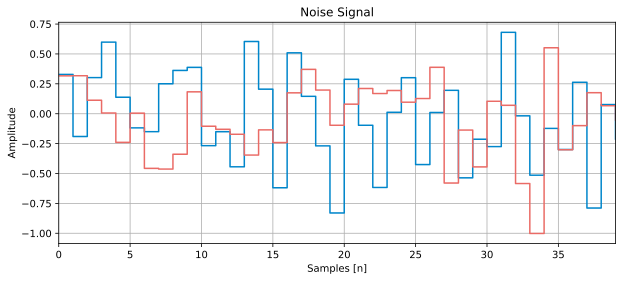

In [7]:
hf.plot_samples('Noise Signal',
                [range(len(noise_I)),range(len(noise_Q))],
                [noise_I,noise_Q])

We can also inspect the PDF of our noise. The blue histogram shows our measured PDF whereas the red line shows the ideal Gaussian PDF given our desired standard deviation. The parameter *b* can be varied to change the number of bins, or the resolution along the x-axis.

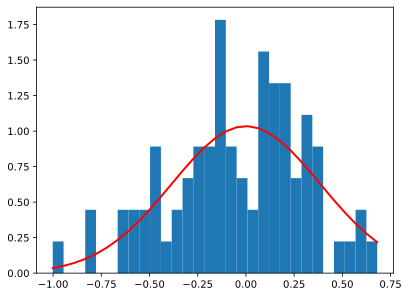

In [8]:
hf.plot_hist('',np.concatenate((noise_I,noise_Q)),std_noise,b=30)

### 3.3. Add Noise <a class="anchor" id="add_noise"></a>
To add the generated noise to our signal, we simply add the two arrays together. The cell below performs this addition and plots the encoded noisy signal's samples  as well as a constellation plot. Inspecting these plots, it can be seen as the SNR decreases the ability to determine which symbol a sample belongs to becomes more difficult. This is how errors are introduced.

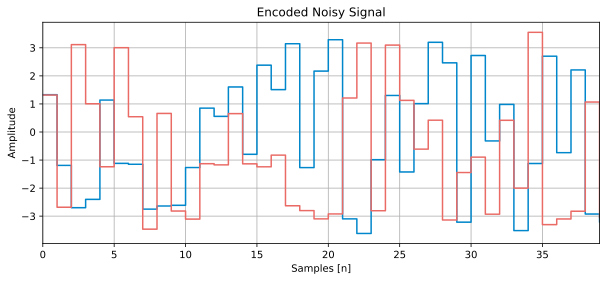

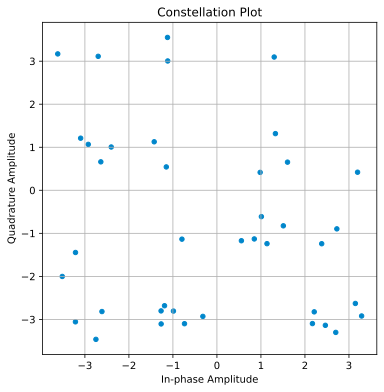

In [9]:
signal_with_noise = signal + noise

hf.plot_samples('Encoded Noisy Signal',
                [range(len(signal_with_noise)),range(len(signal_with_noise))],
                [np.real(signal_with_noise),np.imag(signal_with_noise)])

hf.plot_constellation(signal_with_noise)

We can verify that the correct level of noise has been added to the signal by measuring the SNR.

In [10]:
power_signal = np.var(signal)
power_noise = np.mean(np.abs(signal - signal_with_noise)**2)
snr_db = 10*np.log10(power_signal/ power_noise)
print('Desired SNR: ', SNR)
print('Measured SNR: ', snr_db)

Desired SNR:  15
Measured SNR:  15.817492474645029


## 4. Log Likelihood Ratio (Soft Demodulation) <a class="anchor" id="llr"></a>
Once a signal has been received, it must be baseband demodulated. This is the opposite process to baseband modulation. We receive a signal with noise and must determine which symbol a sample belongs to so that we can convert that symbol back into the original serial sequence. If there is no or little noise in a channel, then this process can be relatively simple. Boundaries around the symbols can be drawn up and if a sample falls within a boundary's region, then it must belong to that symbol. An example of this is shown in Figure 3 below.

<a class="anchor" id="fig-3"></a>
<center><figure>
<img src='../img/scaled_symbol_mapping_boundaries.svg' width='800'/>
    <figcaption><b>Figure 3: Gray coded symbol mapping constellation for 16-QAM with decision boundaries.</b></figcaption>
</figure></center>

This straight conversion from a sample back to a symbol can be referred to as a **hard** decision and results in hard bits. There is no nuance in the decision made. A sample could be right on the boundary between symbols and, after baseband demodulation, the resulting bits would have the same perceived certainty that the bits resulting from a sample that aligns perfectly with a symbol has. Therefore, making hard decisions can lead to errors.

When decoding data and performing error correction, it is beneficial to instead make **soft** decisions during this process. Soft decisions return soft bits which convey the confidence that a bit is either a 1 or a 0. In doing this, the decoder is able to form a better estimate of the original data which can result in fewer errors than if hard decisions were employed. 

The name Soft Decision Forward Error Correction (SD-FEC) of the integrated blocks found in some Xilinx RFSoC devices means it should be of no surprise that soft bits are the form accepted by the decoder. Soft bits themselves can come in different formats. The particular form of soft bit accepted by the SD-FEC core is **Log-Likelihood Ratio (LLR)**. The LLR is calculated for each bit in a symbol and is defined as: 

$$
    \mathit{LLR(b)} = ln\left(\frac{Pr(b=1)}{Pr(b=0)}\right)\\
$$
This means that positive values (including 0) are interpreted as a hard binary 1 and negative values are interpreted as a hard binary 0. The magnitude of these values indicates the certainty, with a larger magnitude equating to a higher certainty and vice versa.

This calculation can be reduced to a series of if-statements for easy implementation. Krishna Sankar has written an excellent [blog](http://www.dsplog.com/2009/07/05/softbit-16qam/) on how soft bits can be calculated when demapping 16-QAM signals. For our 16-QAM mapping, the resulting conditional statements are:

$$
\begin{gather}
  llr(b3) = 
  \begin{cases}
      2(y_{re}+1) &\;\;\;: \text{if}\; y_{re} < -2\\
      \;\;\;\;y_{re} &\;\;\; : \text{if}\; -2 \leq y_{re} < 2\\
      2(y_{re}-1) &\;\;\; : \text{if}\; y_{re} > 2
  \end{cases}
\end{gather}
$$
<br>
<br>
$$
\begin{gather}
  llr(b2) = \;\; -|y_{re}|+2 &&\; \forall \; y_{re}  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\end{gather}
$$
<br>
<br>
$$
\begin{gather}
  llr(b1) = 
  \begin{cases}
      -2(y_{im}+1) & : \text{if}\; y_{im} < -2\\
      \;\;\;\;-y_{im} & : \text{if}\; -2 \leq y_{im} < 2\\
      -2(y_{im}-1) & : \text{if}\; y_{im} > 2
  \end{cases}
\end{gather}
$$
<br>
<br>
$$
\begin{gather}
  llr(b0) = \;\; -|y_{im}|+2 &&\; \forall  \; y_{im} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\end{gather}
$$

This is easily implemented in Python. The cell below iterates through each sample in the noisy signal and returns 4 LLR values, one for each bit in the symbol, for each sample in the signal.

In [11]:
llrs = []
for y in signal_with_noise:
    # Bit 3
    if y.real < -2:
        b3 = 2*(y.real+1)
    elif y.real >= -2 and y.real < 2:
        b3 = y.real
    elif y.real > 2:
        b3 = 2*(y.real-1)
        
    # Bit 2
    b2 = -abs(y.real)+2
    
    # Bit 1
    if y.imag < -2:
        b1 = -2*(y.imag+1)
    elif y.imag >= -2 and y.imag < 2:
        b1 = -y.imag
    elif y.imag > 2:
        b1 = -2*(y.imag-1) 
        
    # Bit 0
    b0 = -abs(y.imag)+2
    
    llrs.append(b3)
    llrs.append(b2)
    llrs.append(b1)
    llrs.append(b0)

We can visually examine how the soft decisions have performed by comparing the first 80 LLR values with the first 80 bits in the uncorrupted serial data. Executing the cell below will plot these two signals. The blue plot shows the LLR values and the red the serial data before noise was added. Remember that positive and zero LLR values indicate a 1 and negative LLR values a 0. The LLR magnitude indicates the certainty so if any errors are observed here, the LLR value should have a small magnitude. Try changing the SNR and running the previous cells again to see how this plot is affected by noise.

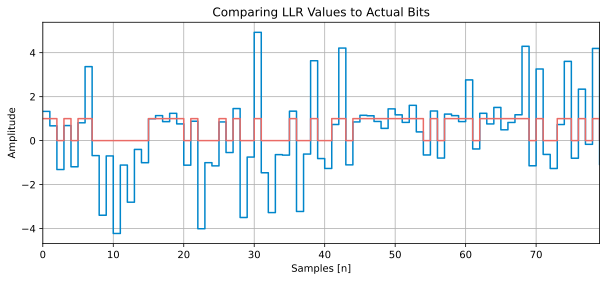

In [12]:
hf.plot_samples('Comparing LLR Values to Actual Bits',
                [range(80),range(80)],
                [llrs[0:80], rx_bits[0:80]])

Finally, store the LLR values so that they can be used in the following notebook.

In [13]:
%store llrs

Stored 'llrs' (list)


## 5. Conclusion <a class="anchor" id="nb3_conclusion"></a>
This notebook has shown a simplified radio communications pipeline, where encoded serial data has been mapped into symbols, subjected to a noise channel, and demapped using soft decisions into soft bits. 

---

[⬅️ Previous Notebook](15_dec_first_principles.ipynb) || [Next Notebook 🚀](17_ofdm_fundamentals.ipynb)

---